# Qual Analysis and Exploratory

In [1]:
import os
import pprint
import tqdm
import json
import glob
import jsonlines
import pprint
import pandas as pd
import pickle
import numpy as np
import subprocess
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

import sys
from collections import Counter
import subprocess
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
import datetime
import h5py
from typing import NamedTuple
import re
import statsmodels.api as sm
from scipy.stats import bernoulli 
from collections import defaultdict
from operator import attrgetter
import statsmodels.formula.api as smf
from pandas.plotting import scatter_matrix
import networkx as nx

#load in search hashtags
with open('../references/search_hashtags.txt', 'r') as f:
    search_hashtags = f.readlines()
    search_hashtags = [i.replace('\n', '') for i in search_hashtags]
    search_hashtags = [i.replace('#', '') for i in search_hashtags]
    search_hashtags = [i.lower() for i in search_hashtags]
    search_hashtags.remove('وأناكمان')

# Parameters

In [2]:
group_num = 3
hashtag_split = True
ngram_range = '34'
min_user = 100

plot_save_path = f'/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/results/0{group_num}_group/'

overwrite = True
read_in = True

def unit_conv(val):
    return datetime.datetime.strptime('2017-10-16', '%Y-%m-%d') + datetime.timedelta(days=int(val))

def reverse_unit_conv(date):
    return (datetime.datetime.strptime(date, '%Y-%m-%d') - datetime.datetime.strptime('2017-10-16', '%Y-%m-%d')).days

class daterange(NamedTuple):
    start: str
    end: str

#obtain peak times again
with h5py.File('/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/data/02_intermediate/FAS_peak_analysis.hdf5', 'r') as f:
    FAS_peaks = f['peak_detections']
    x = f['segments']['selected_ranges'][int(group_num)-1]
    group_date_range = daterange(
        start = x[0].decode(),
        end = x[1].decode()
    )

    group_start_index = reverse_unit_conv(group_date_range.start)
    group_end_index = reverse_unit_conv(group_date_range.end)

    most_prominent_peaks = {}
    for name, h5obj in FAS_peaks.items():

        peak_locations = h5obj['peak_locations']
        peak_locations = [(i,e) for i,e in enumerate(h5obj['peak_locations']) if (unit_conv(e) > datetime.datetime.strptime(group_date_range.start, '%Y-%m-%d')) and (unit_conv(e) < datetime.datetime.strptime(group_date_range.end, '%Y-%m-%d'))]
        peak_indices = [i[0] for i in peak_locations]
        prominences = [element for index, element in enumerate(h5obj['prominences']) if index in peak_indices]
        if len(prominences) == 0:
            continue
        max_prominence = np.argmax(prominences)
        most_prominent_peaks[name] = unit_conv(peak_locations[max_prominence][1])

most_prominent_peaks

{'kutoo': datetime.datetime(2020, 2, 28, 0, 0),
 'metoo': datetime.datetime(2020, 2, 24, 0, 0),
 'moiaussi': datetime.datetime(2020, 2, 5, 0, 0),
 'niunamenos': datetime.datetime(2020, 3, 8, 0, 0),
 'tôicũngvậy': datetime.datetime(2020, 3, 8, 0, 0),
 'watashimo': datetime.datetime(2020, 2, 28, 0, 0),
 'ятоже': datetime.datetime(2020, 2, 8, 0, 0),
 '나도당했다': datetime.datetime(2020, 3, 8, 0, 0)}

In [3]:
# read df raw for ABM
stats_df_save_dir = '/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/data/06_reporting/'
df_filename = os.path.join(stats_df_save_dir, f'ABM_raw_df_group_{group_num}.obj')
stats_filename = os.path.join(stats_df_save_dir, f'ABM_stats_df_group_{group_num}.obj')

if os.path.isfile(df_filename):
    print('reading in df')
    with open(df_filename, 'rb') as f:
        df = pickle.load(f)
if os.path.isfile(stats_filename):
    print('reading in stats_df')
    with open(stats_filename, 'rb') as f:
        stats_df = pickle.load(f)

print('N.B. users are not included in stats df because in creating the activity counts users were split into before and after peak interactions')

print(f'Length of df: {len(df)}')
unique_author_stats_df_count = len(stats_df['author_id'].unique())
print(f'Number of unique authors in df: {unique_author_stats_df_count}')
unique_author_df_count = len(df['author_id'].unique())
print(f'Number of unique authors in stats_df: {unique_author_df_count}')


reading in df
reading in stats_df
N.B. users are not included in stats df because in creating the activity counts users were split into before and after peak interactions
Length of df: 5603979
Number of unique authors in df: 9622
Number of unique authors in stats_df: 9674


In [4]:
# generate ht column - sort of reverse of 
df_colnames = df.columns
vocab_colnames = [i for i in df_colnames if i.startswith('vocab')][::-1]
def process_row_ht(row):
    for col in vocab_colnames:
        if col == 'vocab:#timesup':
            continue
        if row[col] == 1:
            return col.split('#')[-1]
    return None

df['ht'] = df.apply(process_row_ht, axis=1)
df['ht'] = df['ht'].fillna('metoo')

df = df.merge(stats_df, on=['author_id','ht'], how='right')

## Insert Primary HT into full df

In [5]:
FAS_volume_df = pd.read_hdf('/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/data/02_intermediate/FAS_peak_analysis.hdf5', key='plot_data')

num_users_group = len(glob.glob(f'/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/data/01_raw/0{group_num}_group/timeline*.jsonl'))

expected_counts = FAS_volume_df[(FAS_volume_df['created_at']<group_date_range.end) & (FAS_volume_df['created_at']>group_date_range.start)].groupby('hashtag').sum()/num_users_group

# incorporate primary ht
with open(f'/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/data/03_processed/primary_ht_global.obj', 'rb') as f:
    user_order, res = pickle.load(f)

unknown_count = 0
def process_primary_res(author_id):
    global unknown_count
    if author_id not in user_order:
        # print(f'{author_id} not in users')
        unknown_count += 1
        return 'metoo'
    return search_hashtags[np.argmax(res[user_order.index(author_id),:])]

df['primary_ht'] = df['author_id'].map(df.groupby('author_id').apply(lambda x: process_primary_res(x.name)))
print(f'Number of unknown primary hashtags for users: {unknown_count}')

Number of unknown primary hashtags for users: 0


# Exploratory

What would be informative?
* Which users show the strongest signals?
* PCA on the metrics in the scatter matrices

In [6]:
print(stats_df.columns)

pca_colnames = [
    'int_pre_peak',
    'act_pre_peak',
    'norm_act_pre_peak',
    'likes_std',
    'percent_reciprocal'
]

pca_df = stats_df.loc[:,pca_colnames]
pca_df = pca_df.fillna(0)
pca_df = StandardScaler().fit_transform(pca_df)
pca_df

Index(['author_id', 'int_pre_peak', 'act_pre_peak', 'norm_act_pre_peak',
       'act_pre_peak_avg', 'norm_act_pre_peak_avg', 'act_post_peak',
       'act_post_peak_avg', 'ht', 'likes_std', 'org', 'age', 'gender', 'lang',
       'hashtag_lang', 'lang_diff', 'same_cluster_change', 'weight',
       'reciprocal', 'percent_reciprocal'],
      dtype='object')


array([[ 0.20937807, -0.04044588,  0.45538437,  0.17557222, -0.02125039],
       [ 4.66183312, -0.04044588,  4.08368872, 12.12826086, -0.02125039],
       [-0.53290225, -0.04044588, -0.50048902, -0.43491456, -0.02125039],
       ...,
       [-0.53106189, -0.04044588, -0.56555209, -0.40278368, -0.02125039],
       [-0.53658298, -0.04044588, -0.55586185, -0.43491456, -0.02125039],
       [ 0.35599377, -0.04044588,  0.01413217,  0.36835752, -0.02125039]])

In [7]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(pca_df)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [8]:
principalDf

,principal component 1,principal component 2
0,0.473176,-0.059090
1,12.019933,-0.590509
2,-0.849057,-0.013875
3,3.233871,-0.144225
4,3.707298,-0.188984
...,...,...
109521,-0.568984,-0.021702
109522,-0.475720,-0.032847
109523,-0.864537,-0.014058
109524,-0.881132,-0.013002


In [19]:
finalDf = pd.concat([principalDf, stats_df['act_post_peak']>5], axis = 1)
finalDf.columns = ['Principal Component 1', 'Principal Component 2', 'Participated']
finalDf

,Principal Component 1,Principal Component 2,Participated
0,0.473176,-0.059090,False
1,12.019933,-0.590509,False
2,-0.849057,-0.013875,False
3,3.233871,-0.144225,False
4,3.707298,-0.188984,False
...,...,...,...
109521,-0.568984,-0.021702,False
109522,-0.475720,-0.032847,False
109523,-0.864537,-0.014058,False
109524,-0.881132,-0.013002,False


<AxesSubplot:xlabel='Principal Component 1', ylabel='Principal Component 2'>

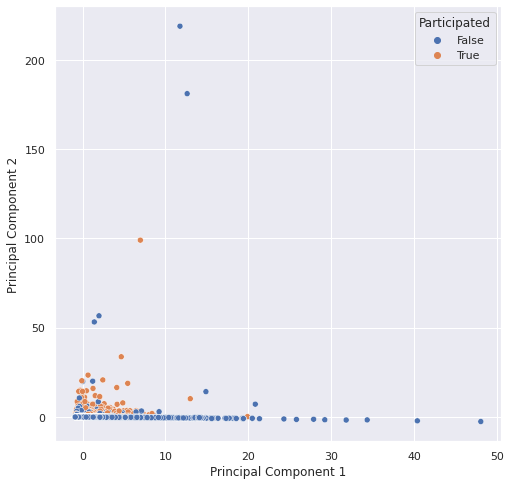

In [24]:
fig = plt.figure(figsize = (8,8))
# ax = fig.add_subplot(1,1,1) 
# ax.set_xlabel('Principal Component 1', fontsize = 15)
# ax.set_ylabel('Principal Component 2', fontsize = 15)
sns.scatterplot(x='Principal Component 1', y='Principal Component 2', data=finalDf, hue='Participated', markers=["o", "x"])

/home/hubert/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not r

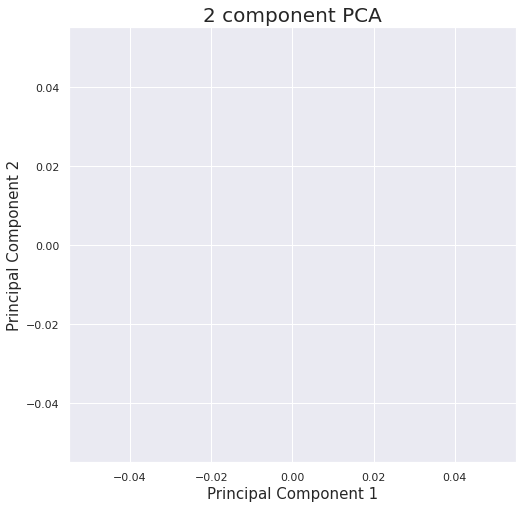

In [13]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = ['participated', 'not participated']
colors = ['r', 'g']
for target, color in zip(targets,colors):
    if target == 'participated':
        indicesToKeep = finalDf['act_post_peak']
    else:
        indicesToKeep = finalDf['act_post_peak']==False
    sns.scatterplot(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()
plt.savefig(f'{plot_save_path}pca_numerical_{group_num}.png', bbox_inches='tight', dpi=300)

/home/hubert/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


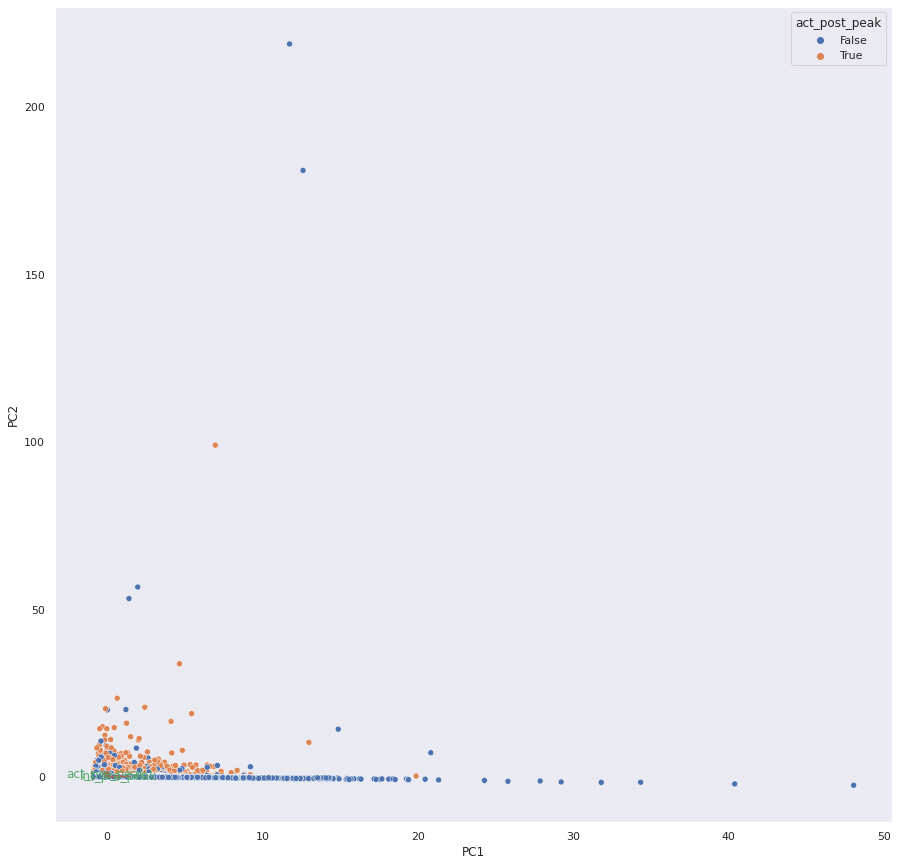

In [25]:
y = stats_df['act_post_peak']>5

def pca_with_var_plot(score,coeff,labels=None):

    # score = pca result
    # coeff = pca.components_

    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]

    sns.scatterplot(xs,ys, hue=y) #without scaling
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1], color = 'r',alpha = 1, width=0.2)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(1,1,1)
sns.color_palette("Set2")
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

#Call the function. 
pca_with_var_plot(principalComponents, pca.components_, labels=pca_colnames)
plt.show()

In [ ]:
pca_colnames

## Factor Analysis

In [ ]:
famd_df_cols = [
    'int_pre_peak',
    'act_pre_peak',
    'norm_act_pre_peak',
    'likes_std',
    'percent_reciprocal',
    'ht',
    'org',
    'age',
    'gender',
    'lang_diff'
]

famd_df = stats_df.loc[:,famd_df_cols]

#creating instance of one-hot-encoder
encoder = OneHotEncoder(handle_unknown='ignore')


In [ ]:
#perform one-hot encoding on 'team' column 
famd_df_final=stats_df.loc[:,pca_colnames]
for col in famd_df.columns:
    if famd_df[col].dtype == 'int64' or famd_df[col].dtype == 'float64':
        pass
    else:
        encoder_df = pd.DataFrame(encoder.fit_transform(famd_df[[col]]).toarray())
        encoder_df = encoder_df.div(np.sqrt(encoder_df.sum(axis=0)/len(encoder_df)), axis=1)
        encoder_df.columns = [f'{col}_{i}' for i in encoder_df.columns]
        famd_df_final = famd_df_final.join(encoder_df, how='left', rsuffix=col)

# #merge one-hot encoded columns back with original DataFrame
# final_df = df.join(encoder_df)

famd_df_final=famd_df_final.fillna(0)
famd_df_final = StandardScaler().fit_transform(famd_df_final)

In [ ]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(famd_df_final)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [ ]:
# plot distribution of act_post_peak
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Post peak activity', fontsize = 15)
ax.hist(stats_df['act_post_peak'], bins = 200);


In [ ]:
stats_df['act_post_peak'].describe()

In [ ]:
finalDf = pd.concat([principalDf, stats_df['act_post_peak']>2], axis = 1)
finalDf

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = ['participated', 'not_participated']
colors = ['r', 'g']
for target, color in zip(targets,colors):
    if target == 'participated':
        indicesToKeep = finalDf['act_post_peak']
    else:
        indicesToKeep = finalDf['act_post_peak']==False
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()
plt.savefig(f'{plot_save_path}pca_combined_{group_num}.png')

In [ ]:
pca.explained_variance_ratio_

In [ ]:
y = stats_df['act_post_peak']>5

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(1,1,1)
sns.color_palette("Set2")
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

#Call the function. 
pca_with_var_plot(principalComponents, pca.components_, labels=pca_colnames)
plt.show()

## KModes/KPrototypes

[HUANG97]	(1, 2) Huang, Z.: Clustering large data sets with mixed numeric and categorical values, Proceedings of the First Pacific Asia Knowledge Discovery and Data Mining Conference, Singapore, pp. 21-34, 1997.
[HUANG98]	Huang, Z.: Extensions to the k-modes algorithm for clustering large data sets with categorical values, Data Mining and Knowledge Discovery 2(3), pp. 283-304, 1998.
[CAO09]	Cao, F., Liang, J, Bai, L.: A new initialization method for categorical data clustering, Expert Systems with Applications 36(7), pp. 10223-10228., 2009.

Methods of combining clustering for both numerical and categorical variables

In [ ]:
famd_df = famd_df.fillna(0)

In [ ]:
famd_df.columns

In [ ]:
from kmodes.kprototypes import KPrototypes

kproto = KPrototypes(n_clusters=2, verbose=2, max_iter=20)
kproto.fit(famd_df, categorical=[5,6,7,8,9])

# clusters = KPrototypes().fit_predict(X, categorical=[1, 2])

In [ ]:
clusters = kproto.predict(famd_df, categorical=[5,6,7,8,9])

In [ ]:
famd_df['clusters'] = list(clusters)
famd_df[famd_df['clusters']==0]

# Full df exploratory

* get a sense that majority of people don't do much
* get an idea of that 95%/5% split.
* what do they look like behaviourally speaking?

In [5]:
# filter df to detectable signal output
activated_idx = stats_df['act_post_peak'] > 10

stats_df[activated_idx]

,author_id,int_pre_peak,act_pre_peak,norm_act_pre_peak,act_pre_peak_avg,norm_act_pre_peak_avg,act_post_peak,act_post_peak_avg,ht,likes_std,org,age,gender,lang,hashtag_lang,lang_diff,same_cluster_change,weight,reciprocal,percent_reciprocal
28,1004017502551064576,270,4.0,270,0.160000,10.800000,11.0,0.611111,kutoo,7,False,<=18,True,un,ja,True,1.000000,4.0,0.0,0.00000
188,1025334838792863745,205,3.0,468,0.120000,18.720000,13.0,0.722222,kutoo,0,False,19-29,False,un,ja,True,-1.000000,1.0,0.0,0.00000
297,1037850739710734337,150,6.0,378,0.240000,15.120000,13.0,0.722222,kutoo,3,False,19-29,False,un,ja,True,1.000000,2.0,0.0,0.00000
588,1079422320,2039,2.0,5231,0.080000,209.240000,18.0,1.000000,kutoo,4,False,<=18,False,un,ja,True,NaN,NaN,NaN,NaN
659,1086406099371061248,1027,0.0,3135,0.000000,125.400000,13.0,0.722222,kutoo,5,False,19-29,False,un,ja,True,0.000000,1.0,0.0,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34184,53709633,242,0.0,292,0.000000,8.588235,45.0,5.000000,niunamenos,4,False,30-39,False,es,es,False,-1.000000,2.0,0.0,0.00000
34387,583043908,2048,84.0,2181,2.470588,64.147059,20.0,2.222222,niunamenos,77,False,<=18,True,es,es,False,-0.166667,49.0,27.0,0.55102
35143,76593802,35,95.0,5727,2.794118,168.441176,63.0,7.000000,niunamenos,2,False,>=40,False,es,es,False,NaN,NaN,NaN,NaN
35935,879476155039891456,321,2.0,574,0.058824,16.882353,17.0,1.888889,niunamenos,4,False,>=40,False,es,es,False,NaN,NaN,NaN,NaN


In [ ]:
# # plot distribution of interactions for int_pre_peak for the filter on act_post_peak
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Interaction Histogram for High Post Peak Activity', fontsize = 15)
# grouped_activated = df[activated_idx].groupby('author_id').
ax.hist(stats_df[activated_idx]['int_pre_peak'], bins = 50)
plt.show()


In [ ]:
# compared to histogram for interaction activity for all users:

# # plot distribution of interactions for int_pre_peak for the filter on act_post_peak
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Interaction Histogram for All Users', fontsize = 15)
# grouped_activated = df[activated_idx].groupby('author_id').
ax.hist(stats_df['int_pre_peak'], bins = 100)
plt.yscale('log')
plt.show()

In [ ]:
# how about the density of interactions up to their peaks?

df['peak_time'] = df['ht'].apply(lambda x: most_prominent_peaks[x].date())
df['peak_time_delta'] = df['peak_time']-df['created_at']

In [ ]:
# plot histogram of peak time delta
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Peak time delta for all users', fontsize = 15)
# grouped_activated = df[activated_idx].groupby('author_id').
ax.hist(df['peak_time_delta'].dt.total_seconds()/(24 * 60 * 60), bins = 50)
plt.yscale('log')
plt.show()


So on average each user does keep interacting after the peak they participate in

In [ ]:
# # Plot interaction strength in each language
# fig = plt.figure(figsize = (8,8))
# ax = fig.add_subplot(1,1,1)
# for ht in df['ht'].unique():
#     ht_indices = df['ht']==ht
#     daily_counts = df[ht_indices].groupby('created_at').count()
#     ax.scatter(finalDf.loc[indicesToKeep, 
#                , finalDf.loc[indicesToKeep, 'principal component 2']
#                , c = color
#                , s = 50)
#     temp_df

In [ ]:
# df.groupby(['created_at','ht']).count()

In [6]:
fig = plt.figure(figsize = (16,9))

sns_df = df.groupby(['created_at','ht']).count()
sns_df['tweet_id'] = np.log(sns_df['tweet_id'])

# Draw line plot of size and total_bill with parameters and hue "day"
sns.lineplot(
    x = "created_at", y = "tweet_id", data = sns_df, hue = "ht",
            style = "ht", palette = "hot", dashes = False,  legend="brief",)
 
plt.title("Interactions per day per hashtag", fontsize = 20)
plt.xlabel("Date", fontsize = 15)
plt.ylabel("Interactions (log scale)", fontsize = 15)
plt.savefig(f'{plot_save_path}overall_interactions_{group_num}.png', transparent=True, bbox_inches='tight', dpi=300)
plt.show();

KeyboardInterrupt: 

<Figure size 1152x648 with 0 Axes>

# Plot interactions per hashtag and subsequent activity

In [ ]:
# find users with max signal
stats_df.sort_values(by=['act_post_peak'],ascending=False)

In [ ]:
user_to_examine = '101381642'
usertype = 'low'

class daterange(NamedTuple):
    start: str
    end: str

activity_file = '/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/data/03_processed/activity_counts.hdf5'

# obtain user activity
with h5py.File(activity_file, 'r') as f:
    activity = f[f'group_{group_num}'][user_to_examine]['hashtagged'][:]
    feature_order = f[f'group_{group_num}'][user_to_examine]['hashtagged'].attrs['feature_order']
    feature_order = feature_order.split(';')

with h5py.File('/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/data/02_intermediate/FAS_peak_analysis.hdf5', 'r') as f:
    FAS_peaks = f['peak_detections']
    x = f['segments']['selected_ranges'][int(group_num)-1]
    group_date_range = daterange(
        start = x[0].decode(),
        end = x[1].decode()
    )

daterange = pd.date_range(start=group_date_range.start, end=group_date_range.end)
if group_num == 1:
    daterange = pd.date_range(start=group_date_range.start, end='2018-05-30')

plot_user_df = pd.DataFrame({
    'created_at' : daterange})

for index, feature in enumerate(feature_order):
    plot_user_df[f'activity_{feature}'] = activity[index,:]

plot_user_df=pd.wide_to_long(plot_user_df, stubnames='activity', i='created_at', j='ht', sep = '_', suffix='.*').reset_index()

user_df = df[df['author_id']==user_to_examine]
user_df = user_df.groupby(['created_at', 'ht']).count()['tweet_id'].reset_index()
user_df['created_at'] = pd.to_datetime(user_df['created_at'])
final_user_plot_df = user_df.merge(plot_user_df, on = ['created_at','ht'], how='left')
final_user_plot_df.columns = ['created_at', 'Hashtag', 'Interaction Count', 'Hashtag Protest Network Activity']

# final_user_plot_df['interaction_count'] = final_user_plot_df['activity']-final_user_plot_df['tweet_id']
# final_user_plot_df = final_user_plot_df.drop(['tweet_id'])

In [ ]:
df[df['author_id']==user_to_examine]

In [ ]:
temp = df.groupby(['author_id','ht']).count().reset_index()
temp = temp[['author_id', 'ht']].groupby('author_id').count()
temp[temp['ht']>1]

In [ ]:
final_user_plot_df

In [ ]:
pd.melt(final_user_plot_df, ['created_at','Hashtag'])

In [ ]:
fig = plt.figure(figsize = (16,9))

# Draw line plot of size and total_bill with parameters and hue "day"
sns.lineplot(
    x = "created_at", y = "value", hue='variable',data=pd.melt(final_user_plot_df, ['created_at','Hashtag']))
plt.title("Interactions per day per hashtag", fontsize = 20)
plt.xlabel("Date", fontsize = 15)
plt.ylabel("Interactions", fontsize = 15)
plt.savefig(f'{plot_save_path}user_{usertype}_output_{group_num}.png')
plt.show();

# Save Progress for ABM

In [ ]:
ABM_ready_filename = f'/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/data/03_processed/ABM_df_group_{group_num}.obj'

with open(ABM_ready_filename, 'wb') as f:
    pickle.dump(df, f)